In [2]:
import pickle
from huggingface_hub import snapshot_download, HfApi, Repository

snapshot_download(repo_id="amphora/pythia-12b-weights", 
                  local_dir='here',
                  local_dir_use_symlinks=False,
                  allow_patterns="*.pkl")


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

embed_only_110000-143000.pkl:   0%|          | 0.00/35.3G [00:00<?, ?B/s]

embed_only_30000-69000.pkl:   0%|          | 0.00/41.5G [00:00<?, ?B/s]

embed_only_0-29000.pkl:   0%|          | 0.00/41.5G [00:00<?, ?B/s]

embed_only_70000-109000.pkl:   0%|          | 0.00/41.5G [00:00<?, ?B/s]

'/here'

### Cos-Sim with Final Embedding

In [2]:
files = [
 'embed_only_0-29000.pkl',
 'embed_only_30000-69000.pkl',
 'embed_only_70000-109000.pkl',
 'embed_only_110000-143000.pkl'
]

import pickle
import numpy as np
from scipy.spatial.distance import cosine

# Helper function to calculate cosine similarity
def calculate_cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

# Function to load the target embedding
def load_target_embedding(target_file, target_embedding_index):
    with open(target_file, 'rb') as file:
        data = pickle.load(file)
    # Assuming the data is a numpy array of shape (50668, 5012)
    target_embedding = data[target_embedding_index]  # Ensure this is correct
    return target_embedding

# Specify the path and target details
target_file_path = 'here/embed_only_110000-143000.pkl'
target_embedding_index_global = 'step143000'  # Placeholder, adjust as necessary

# Load the target embedding
target_embedding = load_target_embedding(target_file_path, target_embedding_index_global)

In [25]:
# Correct initialization of the dictionary for cosine similarities
cosine_similarities = {i: [] for i in range(50688)}  # Assuming you want to store for each index

# Process each file and calculate cosine similarities
for filename in files:
    file_path = 'here/' + filename
    with open(file_path, 'rb') as file:
        data = pickle.load(file)  # Adjust if data structure is different
        
    # Assuming `data` is a dict with embedding indices as keys and (50668, 5012) arrays as values
    for k, emb in tqdm(data.items(),total=len(data)):
        for i in range(emb.shape[0]):  # Ensure this loops correctly over your embeddings
            word_emb = emb[i, :]
            # Calculate and store the cosine similarity
            cosine_similarities[i].append(calculate_cosine_similarity(target_embedding[i,:], word_emb))


100%|██████████| 34/34 [00:26<00:00,  1.28it/s]


In [46]:
import pickle

# Specify the file path where you want to save the dictionary
file_path = 'cos-sim-w-final.pkl'

# Open the file in binary write mode and use pickle.dump() to save the dictionary
with open(file_path, 'wb') as file:
    pickle.dump(cosine_similarities, file)

print(f'Dictionary has been saved to {file_path}')

Dictionary has been saved to cos-sim-w-final.pkl


In [3]:
import pickle
import numpy as np
from scipy.spatial.distance import cosine
from tqdm import tqdm

files = [
 'embed_only_0-29000.pkl',
 'embed_only_30000-69000.pkl',
 'embed_only_70000-109000.pkl',
 'embed_only_110000-143000.pkl'
]

# Helper function to calculate cosine similarity
def calculate_cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

# Initialize a structure to store the last embedding of each vocab item for comparison with the first embedding of the same vocab in the next file
last_embeddings = {}  # Assuming embeddings are of shape (5012,)

# Initialize the dictionary for rolling cosine similarities
# The key will be a tuple (vocab_idx, file_idx) for clarity, and the value will be the cosine similarity
rolling_cosine_similarities = {i: [] for i in range(50688)}  # Assuming you want to store for each index

file_idx = 0  # To keep track of file order
for filename in files:
    file_path = 'here/' + filename
    with open(file_path, 'rb') as file:
        data = pickle.load(file)  # Assuming data is a dict or array-like structure with embeddings per vocab

    if file_idx > 0:
        data = {**last_embeddings, **data}
    
    keys = list(data.keys())
    for idx,key in tqdm(enumerate(keys[:-1])):
    
        emb = data[key]
        next_emb = data[keys[idx+1]]
        
        for i in range(emb.shape[0]):  # Ensure this loops correctly over your embeddings
            word_emb = emb[i, :]
            word_emb_next = next_emb[i,:]
            # Calculate and store the cosine similarity
            rolling_cosine_similarities[i].append(calculate_cosine_similarity(word_emb_next, word_emb))
    
    
            # Update the last_embedding for the current vocab to be the last embedding in the current file
    last_embeddings[keys[idx+1]] = data[keys[idx+1]] 
    file_idx += 1  # Increment file index after processing each file


39it [00:29,  1.32it/s]
40it [00:25,  1.60it/s]
41it [00:27,  1.52it/s]
36it [00:24,  1.49it/s]


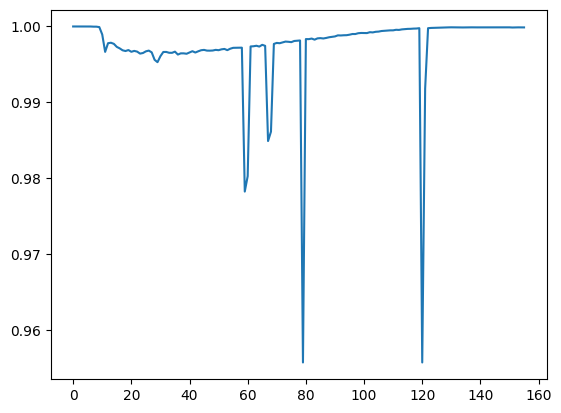

In [10]:
import matplotlib.pyplot as plt

plt.plot(rolling_cosine_similarities[3])